In [ ]:
try:
  import qualtran
except:
  ! pip install git+https://github.com/quantumlib/Qualtran

import functools
import itertools
import attrs
import numpy as np

from qualtran import Bloq, Soquet, Register, QBit, CBit, QUInt, Signature, BloqBuilder
from qualtran.bloqs.arithmetic import BitwiseNot, AddK, Add
from qualtran.bloqs.basic_gates import Hadamard, ZPowGate
from qualtran.simulation.tensor import bloq_to_dense
from qualtran.drawing import show_bloq, show_call_graph
from qualtran.resource_counting import get_cost_value, QECGatesCost, QubitCount

## Integer Negation
The negative of an n-bit integer is its two's complement, complete the foloowin bloq which computes the negate's an unsigned int.

hint: BitwiseNot compute's the one's complement.

In [ ]:
@attrs.frozen
class Negate(Bloq):
  r"""A bloq that maps $\ket{x} \rightarrow \ket{-x \mod 2^n}$"""
  dtype: QUInt

  @functools.cached_property
  def signature(self):
    return Signature.build_from_dtypes(x=self.dtype)

  def build_composite_bloq(self, bb: 'BloqBuilder', x):
    # Write a decomposition of Negate in terms of BitwiseNot and AddK
    x = bb.add(BitwiseNot(self.dtype), x=x)
    x = bb.add(AddK(self.dtype, 1), x=x)
    return {
        'x': x
    }

  def on_classical_vals(self, x):
    return {
        'x': (-x)%(2**self.dtype.bitsize)
    }

  # bonus: implement build_call_graph
  def build_call_graph(self, ssa: 'SympySymbolAllocator'):
    return super().build_call_graph(ssa)

### Visualization

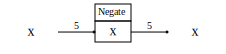

In [ ]:
blq = Negate(QUInt(5))
show_bloq(blq)

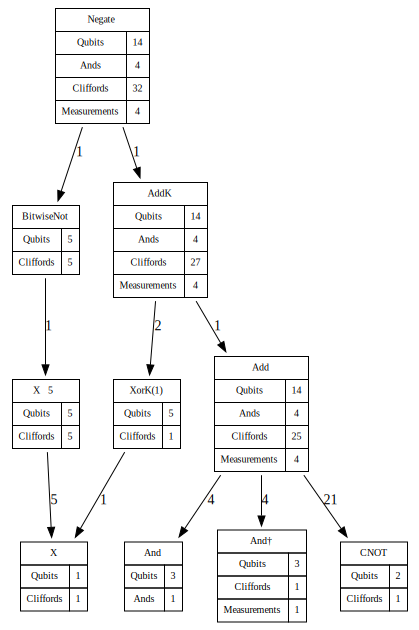

In [ ]:
show_call_graph(blq)

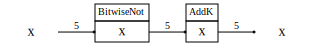

In [ ]:
cblq = blq.decompose_bloq()
show_bloq(cblq)

### Correctness

In [ ]:
for i in range(2**blq.dtype.bitsize):
  assert blq.call_classically(x=i) == cblq.call_classically(x=i)

### Cost

In [ ]:
get_cost_value(blq, QECGatesCost())

GateCounts(t=0, toffoli=0, cswap=0, and_bloq=4, clifford=32, rotation=0, measurement=4)

In [ ]:
get_cost_value(blq, QECGatesCost()).total_t_and_ccz_count()

{'n_t': 0, 'n_ccz': 4}

In [ ]:
get_cost_value(blq, QubitCount())

14

## Subtract

Write a bloq that applies the transformation $|a⟩|b⟩ → |a⟩ |a-b⟩$

In [ ]:
@attrs.frozen
class Subtract(Bloq):
  r"""A bloq that maps $|a⟩|b⟩ → |a⟩ |a-b⟩$"""
  dtype: QUInt

  @functools.cached_property
  def signature(self):
    return Signature.build_from_dtypes(a=self.dtype, b=self.dtype)

  def build_composite_bloq(self, bb: 'BloqBuilder', a, b):
    # write a decomposition of Subtract in terms of the Negate bloq you wrote
    # and qualtran's `Add`
    b = bb.add(Negate(self.dtype), x=b)
    a, b = bb.add(Add(self.dtype), a=a, b=b)

    return {
        'a': a,
        'b': b,
    }

  def on_classical_vals(self, a, b):
    return {
        'a': a,
        'b': (a-b)%(2**self.dtype.bitsize)
    }

  def build_call_graph(self, ssa: 'SympySymbolAllocator'):
    return super().build_call_graph(ssa)

### Visualization And Checking Correctness

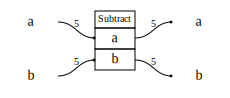

In [ ]:
blq = Subtract(QUInt(5))
show_bloq(blq)

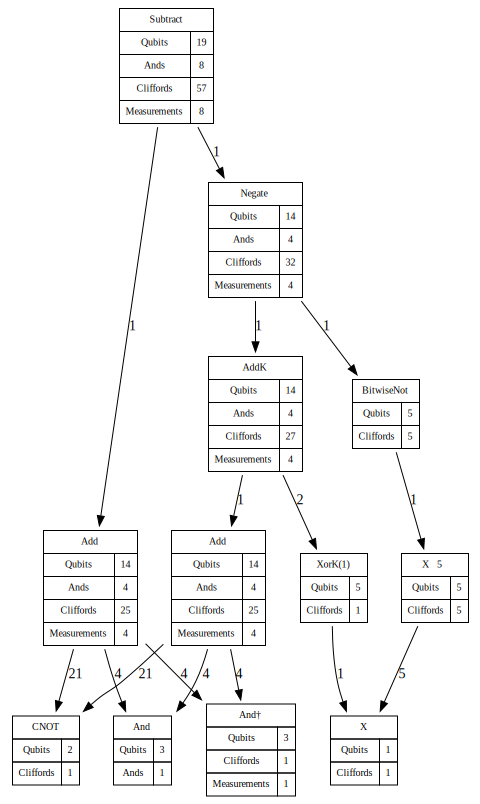

In [ ]:
show_call_graph(blq)

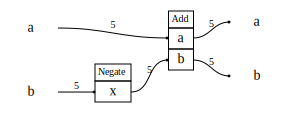

In [ ]:
cblq = blq.decompose_bloq()
show_bloq(cblq)

In [ ]:
for a, b in itertools.product(range(2**blq.dtype.bitsize), repeat=2):
  assert blq.call_classically(a=a, b=b) == cblq.call_classically(a=a, b=b)

In [ ]:
print('number of Toffolis:', get_cost_value(blq, QECGatesCost()).total_toffoli_only())

number of Toffolis: 8


### Optimization
The decomposition above uses $2n-2$ toffolis to subtract two $n$-bit quantum registers, this can be cutdown in half to $n-1$ by using the identity
$$
a-b = \mathtt{\sim}(\mathtt{\sim} a + b)
$$
Proof:

since $\mathtt{\sim}x = -x-1$ we get
$$
\mathtt{\sim}(\mathtt{\sim} a + b) = \mathtt{\sim}(b-a-1) = -(b-a-1)-1 = a-b
$$

In [ ]:
@attrs.frozen
class OptimizedSubtract(Subtract):
  r"""A bloq that maps $|a⟩|b⟩ → |a⟩ |a-b⟩$"""

  def build_composite_bloq(self, bb: 'BloqBuilder', a, b):
    # write a decomposition of Subtract in terms of the Negate bloq you wrote
    # and qualtran's `Add`
    a = bb.add(BitwiseNot(self.dtype), x=a)
    a, b = bb.add(Add(self.dtype), a=a, b=b)
    a = bb.add(BitwiseNot(self.dtype), x=a)
    b = bb.add(BitwiseNot(self.dtype), x=b)

    return {
        'a': a,
        'b': b,
    }

#### Visualization and Correctness

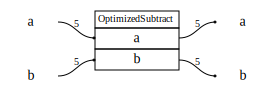

In [ ]:
blq = OptimizedSubtract(QUInt(5))
show_bloq(blq)

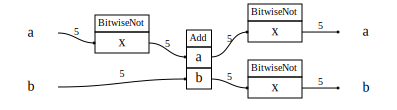

In [ ]:
cblq = blq.decompose_bloq()
show_bloq(cblq)

In [ ]:
for a, b in itertools.product(range(2**blq.dtype.bitsize), repeat=2):
  assert blq.call_classically(a=a, b=b) == cblq.call_classically(a=a, b=b)

In [ ]:
print('number of Toffolis:', get_cost_value(blq, QECGatesCost()).total_toffoli_only())

number of Toffolis: 4


## Quantum Fourier Transform

The quantum fourier transform can built from Hadamards and $R_{k} =$ ZPowGate($1/2^{k-1}$) as

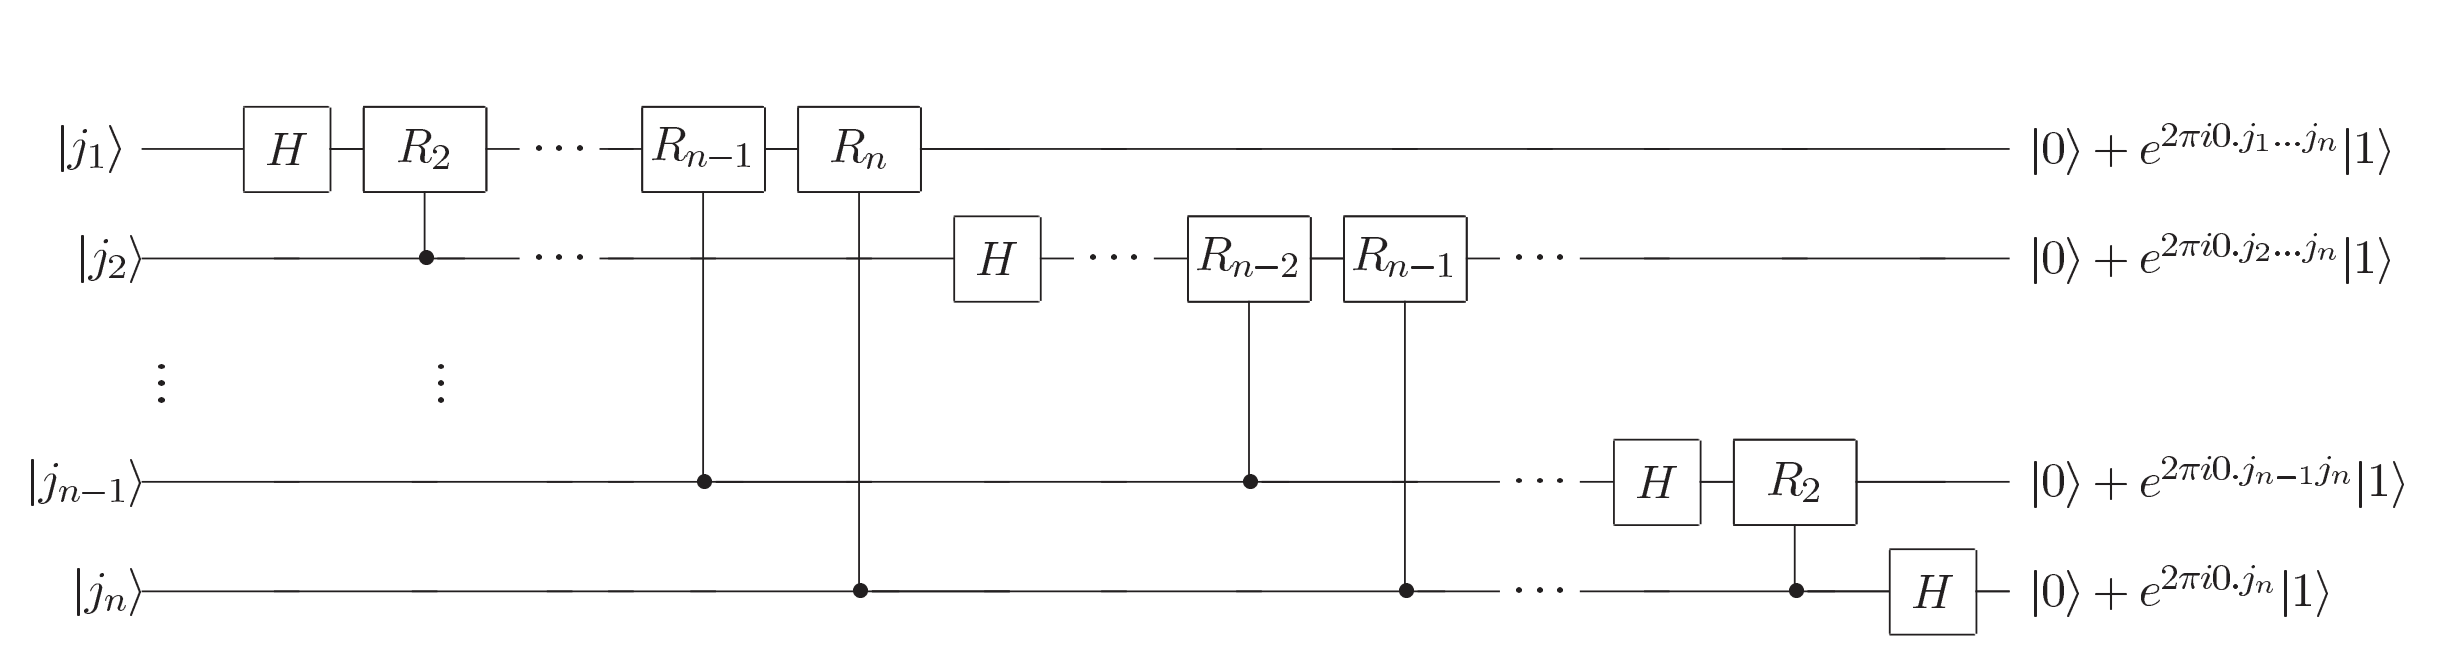

source: figure 5.1 from "quantum computation and quantum information"

Note: the last step of the construction is to reverse the qubits (not shown in the figure)

Note2:

$$
R_k = \begin{bmatrix}
1 & 0\\
0 & e^{i2\pi/2^k}\\
\end{bmatrix}
$$


In [ ]:
@attrs.frozen
class QFT(Bloq):
  r"""A bloq that performs the quantum fourier transform"""
  dtype: QUInt

  @functools.cached_property
  def signature(self):
    return Signature.build_from_dtypes(reg=self.dtype)

  def build_composite_bloq(self, bb: 'BloqBuilder', reg):
    # write a decomposition of Subtract in terms of the Negate bloq you wrote
    # and qualtran's `Add`
    arr = bb.split(reg)
    for i in range(self.dtype.bitsize):
      arr[i] = bb.add(Hadamard(), q=arr[i])
      for j in range(i+1, self.dtype.bitsize):
        arr[j], arr[i] = bb.add(ZPowGate(1/2**(j-i)).controlled(), q=(arr[j], arr[i]))

    arr = arr[::-1]
    reg = bb.join(arr)
    return {
        'reg': reg,
    }


In [ ]:
ZPowGate(1/2**2).controlled().signature

Signature((Register(name='q', dtype=QBit(), _shape=(2,), side=<Side.THRU: 3>),))

In [ ]:
blq = QFT(QUInt(5))

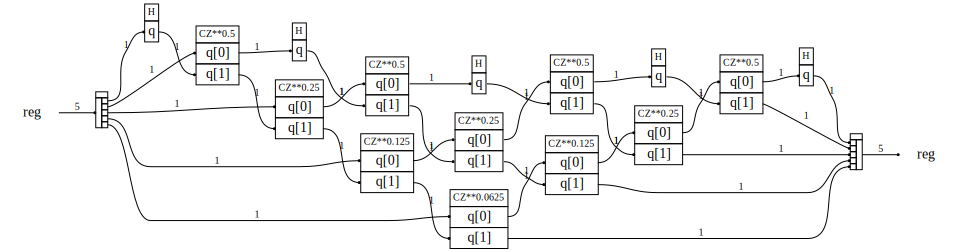

In [ ]:
cblq = blq.decompose_bloq()
show_bloq(cblq)

In [ ]:
my_qft = bloq_to_dense(blq)
my_qft.round(3)

array([[ 0.177+0.j   ,  0.177+0.j   ,  0.177+0.j   , ...,  0.177+0.j   ,
         0.177+0.j   ,  0.177+0.j   ],
       [ 0.177+0.j   ,  0.173+0.034j,  0.163+0.068j, ...,  0.147-0.098j,
         0.163-0.068j,  0.173-0.034j],
       [ 0.177+0.j   ,  0.163+0.068j,  0.125+0.125j, ...,  0.068-0.163j,
         0.125-0.125j,  0.163-0.068j],
       ...,
       [ 0.177+0.j   ,  0.147-0.098j,  0.068-0.163j, ..., -0.034+0.173j,
         0.068+0.163j,  0.147+0.098j],
       [ 0.177+0.j   ,  0.163-0.068j,  0.125-0.125j, ...,  0.068+0.163j,
         0.125+0.125j,  0.163+0.068j],
       [ 0.177+0.j   ,  0.173-0.034j,  0.163-0.068j, ...,  0.147+0.098j,
         0.163+0.068j,  0.173+0.034j]])

In [ ]:
import cirq
cirq_qft = cirq.unitary(cirq.qft(*cirq.LineQubit.range(5)))
cirq_qft.round(3)

array([[ 0.177+0.j   ,  0.177+0.j   ,  0.177+0.j   , ...,  0.177+0.j   ,
         0.177+0.j   ,  0.177+0.j   ],
       [ 0.177+0.j   ,  0.173+0.034j,  0.163+0.068j, ...,  0.147-0.098j,
         0.163-0.068j,  0.173-0.034j],
       [ 0.177+0.j   ,  0.163+0.068j,  0.125+0.125j, ...,  0.068-0.163j,
         0.125-0.125j,  0.163-0.068j],
       ...,
       [ 0.177+0.j   ,  0.147-0.098j,  0.068-0.163j, ..., -0.034+0.173j,
         0.068+0.163j,  0.147+0.098j],
       [ 0.177+0.j   ,  0.163-0.068j,  0.125-0.125j, ...,  0.068+0.163j,
         0.125+0.125j,  0.163+0.068j],
       [ 0.177+0.j   ,  0.173-0.034j,  0.163-0.068j, ...,  0.147+0.098j,
         0.163+0.068j,  0.173+0.034j]])

In [ ]:
np.testing.assert_allclose(cirq_qft, my_qft)

In [ ]:
get_cost_value(blq, QECGatesCost())

GateCounts(t=3, toffoli=0, cswap=0, and_bloq=10, clifford=19, rotation=3, measurement=10)

In [ ]:
get_cost_value(QFT(QUInt(100)), QECGatesCost())

GateCounts(t=98, toffoli=0, cswap=0, and_bloq=4950, clifford=6979, rotation=2923, measurement=4950)

### Obtimization

Remember that
$$
R_k = \begin{bmatrix}
1 & 0\\
0 & e^{i 2\pi/2^k}\\
\end{bmatrix}
$$

which means that as $k$ increases $R_k$ approaches identity and can be dropped, for example at $k=11$ we get a phase of $\pi/1024$. This means that if we decide to keep $R_k$ for $k \leq D$ then instead of $n^2$ gates we end up with $Dn$ gates.

In [ ]:
@attrs.frozen
class ApproixmateQFT(QFT):
  r"""A bloq that performs an approixmation of quantum fourier transform"""
  cutoff_distance: int


  def build_composite_bloq(self, bb: 'BloqBuilder', reg):
    arr = bb.split(reg)
    for i in range(self.dtype.bitsize):
      arr[i] = bb.add(Hadamard(), q=arr[i])
      for j in range(i+1, self.dtype.bitsize):
        if j-i > self.cutoff_distance: break
        arr[j], arr[i] = bb.add(ZPowGate(1/2**(j-i)).controlled(), q=(arr[j], arr[i]))

    arr = arr[::-1]
    reg = bb.join(arr)

    return {
        'reg': reg,
    }


In [ ]:
get_cost_value(ApproixmateQFT(QUInt(100), 10), QECGatesCost())

GateCounts(t=98, toffoli=0, cswap=0, and_bloq=945, clifford=1144, rotation=748, measurement=945)

## Measurement Based Un-Computation (MBUC)

The most expensive operations in fault tolerant computation are the non cliffords like T-gate, Toffoli-gate, ...etc. Most of the time when we want to uncompute an operation we just apply the adjoint of its decomposition in reverse order, which doubles the cost of an operation. However sometimes we can utilize measurement to cut the cost in half. Here we discuss 2 examples the first is addition and the second is $GF(2^n)$ multiplication.

### Addition

[arXiv:1709.06648](https://arxiv.org/abs/1709.06648) used measurements to half the cost of addition by replacing half the toffolis with measurements followed by classically controlled cliffords, this however came at the cost of $n$ ancilla qubits.

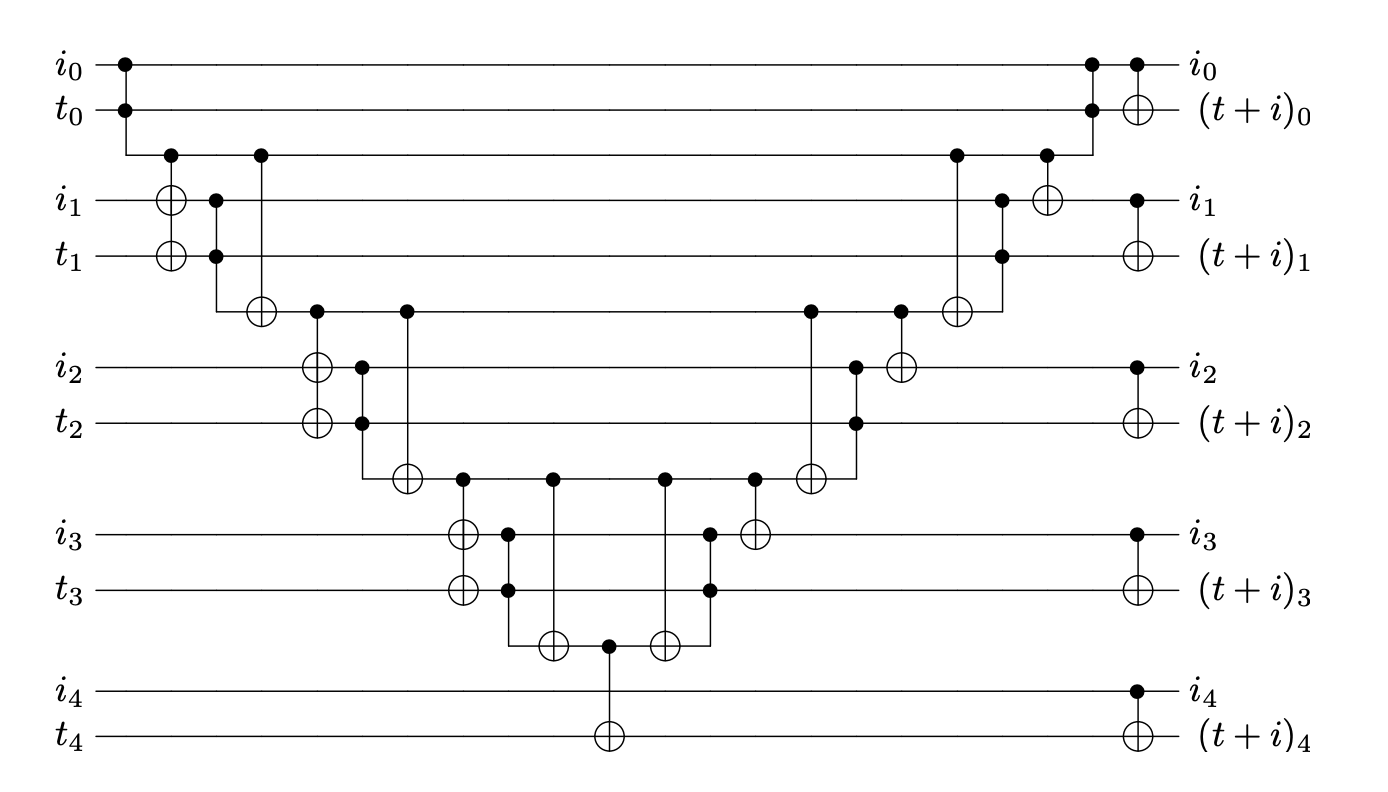

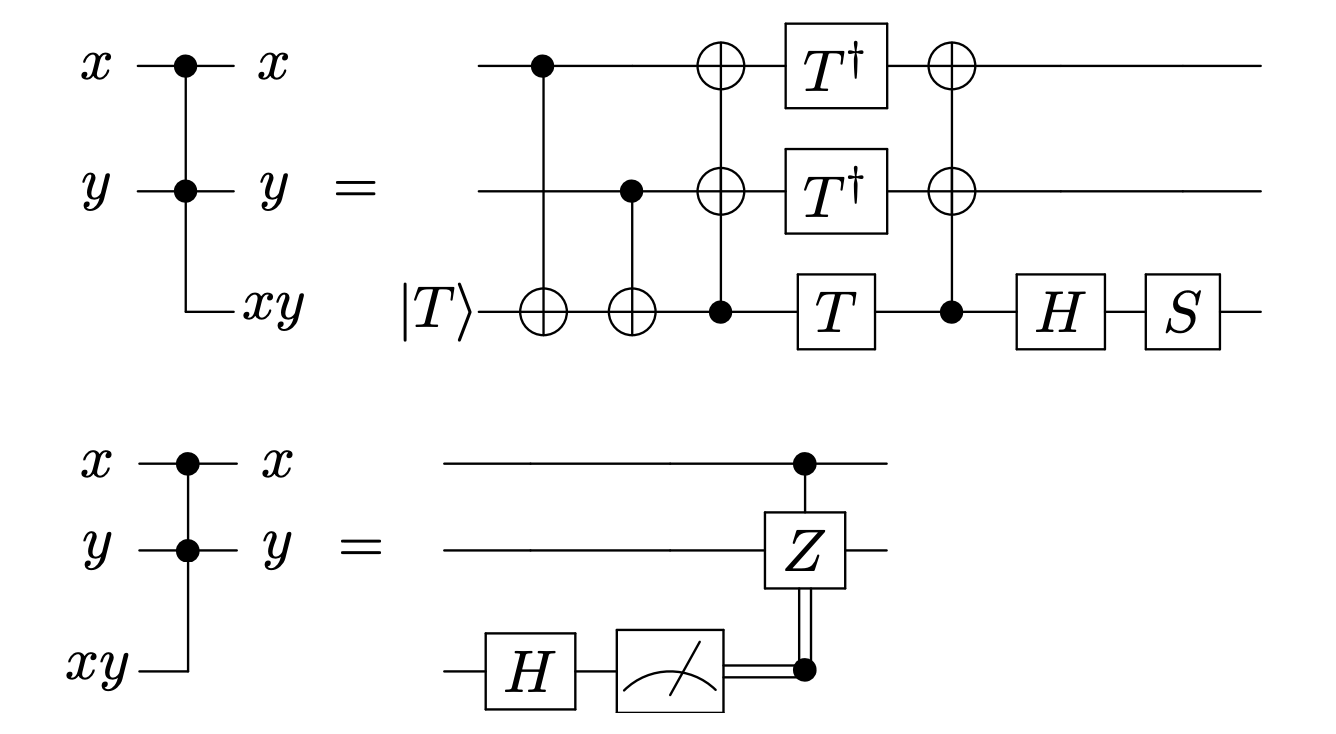

In [ ]:
from qualtran import Side
from qualtran.bloqs.basic_gates import CNOT

@attrs.frozen
class MyAdd(Bloq):
  dtype: QUInt

  @functools.cached_property
  def signature(self):
    return Signature([
      Register('a', self.dtype),
      Register('b', self.dtype),
    ])

  def build_composite_bloq(self, bb: 'BloqBuilder', a, b):

    ancilla = []
    a_arr = bb.split(a)[::-1]
    b_arr = bb.split(b)[::-1]

    for i in range(len(a_arr)-1):
      if i:
        ancilla[-1], a_arr[i] = bb.add(CNOT(), ctrl=ancilla[-1], target=a_arr[i])
        ancilla[-1], b_arr[i] = bb.add(CNOT(), ctrl=ancilla[-1], target=b_arr[i])

      (a_arr[i], b_arr[i]), anc = bb.add(And(), ctrl=(a_arr[i], b_arr[i]))
      if i:
        ancilla[-1], anc = bb.add(CNOT(), ctrl=ancilla[-1], target=anc)

      ancilla.append(anc)


    ancilla[-1], b_arr[-1] = bb.add(CNOT(), ctrl=ancilla[-1], target=b_arr[-1])


    for i in reversed(range(len(a_arr)-1)):
      anc = ancilla.pop()

      if i:
        ancilla[-1], anc = bb.add(CNOT(), ctrl=ancilla[-1], target=anc)

      a_arr[i], b_arr[i] = bb.add(And().adjoint(), ctrl=(a_arr[i], b_arr[i]), target=anc)

      if i:
        ancilla[-1], a_arr[i] = bb.add(CNOT(), ctrl=ancilla[-1], target=a_arr[i])

    for i in range(len(a_arr)):
      a_arr[i], b_arr[i] = bb.add(CNOT(), ctrl=a_arr[i], target=b_arr[i])

    a = bb.join(a_arr[::-1])
    b = bb.join(b_arr[::-1])
    return {
        'a': a,
        'b': b,
    }

  def on_classical_vals(self, a, b):
    return {
      'a': a,
      'b': (a+b)%(2**self.dtype.bitsize),
    }

  # bonus: implement build_call_graph
  def build_call_graph(self, ssa: 'SympySymbolAllocator'):
    return super().build_call_graph(ssa)

#### Visualization And Correctness

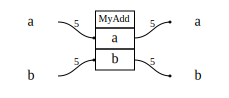

In [ ]:
blq = MyAdd(QUInt(5))
show_bloq(blq)

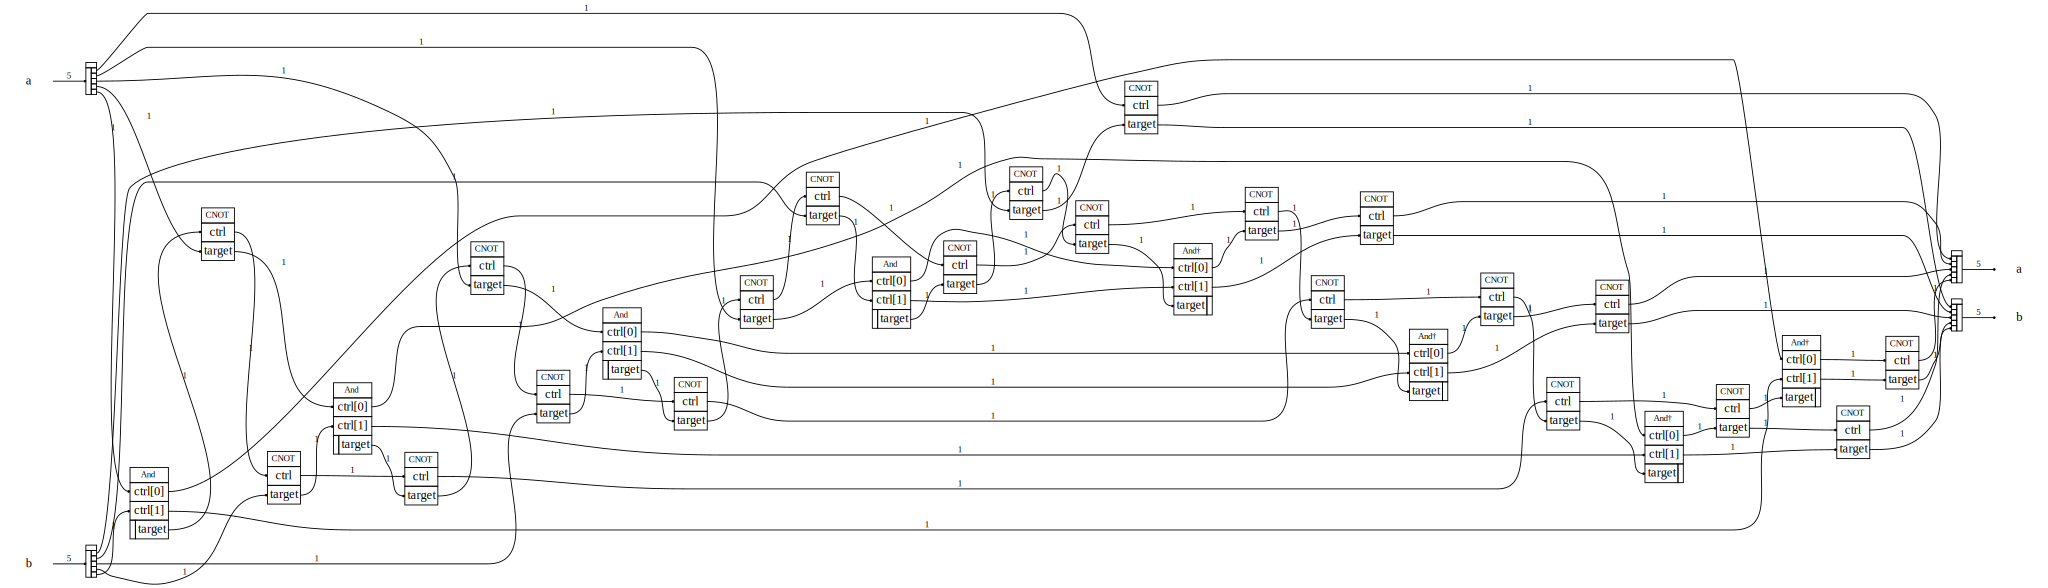

In [ ]:
cblq = blq.decompose_bloq()
show_bloq(cblq)

In [ ]:
for a, b in itertools.product(range(blq.dtype.bitsize), repeat=2):
  assert blq.call_classically(a=a, b=b) == cblq.call_classically(a=a, b=b)

In [ ]:
get_cost_value(blq, QECGatesCost())

GateCounts(t=0, toffoli=0, cswap=0, and_bloq=4, clifford=25, rotation=0, measurement=4)

### GF(2^n) multiplication

The multiplication of binary galois field elements is usually defined out of place as $|a⟩|b⟩|0⟩→|a⟩|b⟩|ab⟩$ and is a costly operation that consumes $O(n^{\log_2{3}})$ Toffoli gates when using karatsuba multiplication. We often need to uncompute the multiplication to restore the ancilla qubits, a nieve approach will double the cost of the operation. However the uncomputation of this operation can be done using only measurements and $CZ$ gates.

see: Appendix C3 of [arXiv:2510.10967](https://arxiv.org/abs/2510.10967)

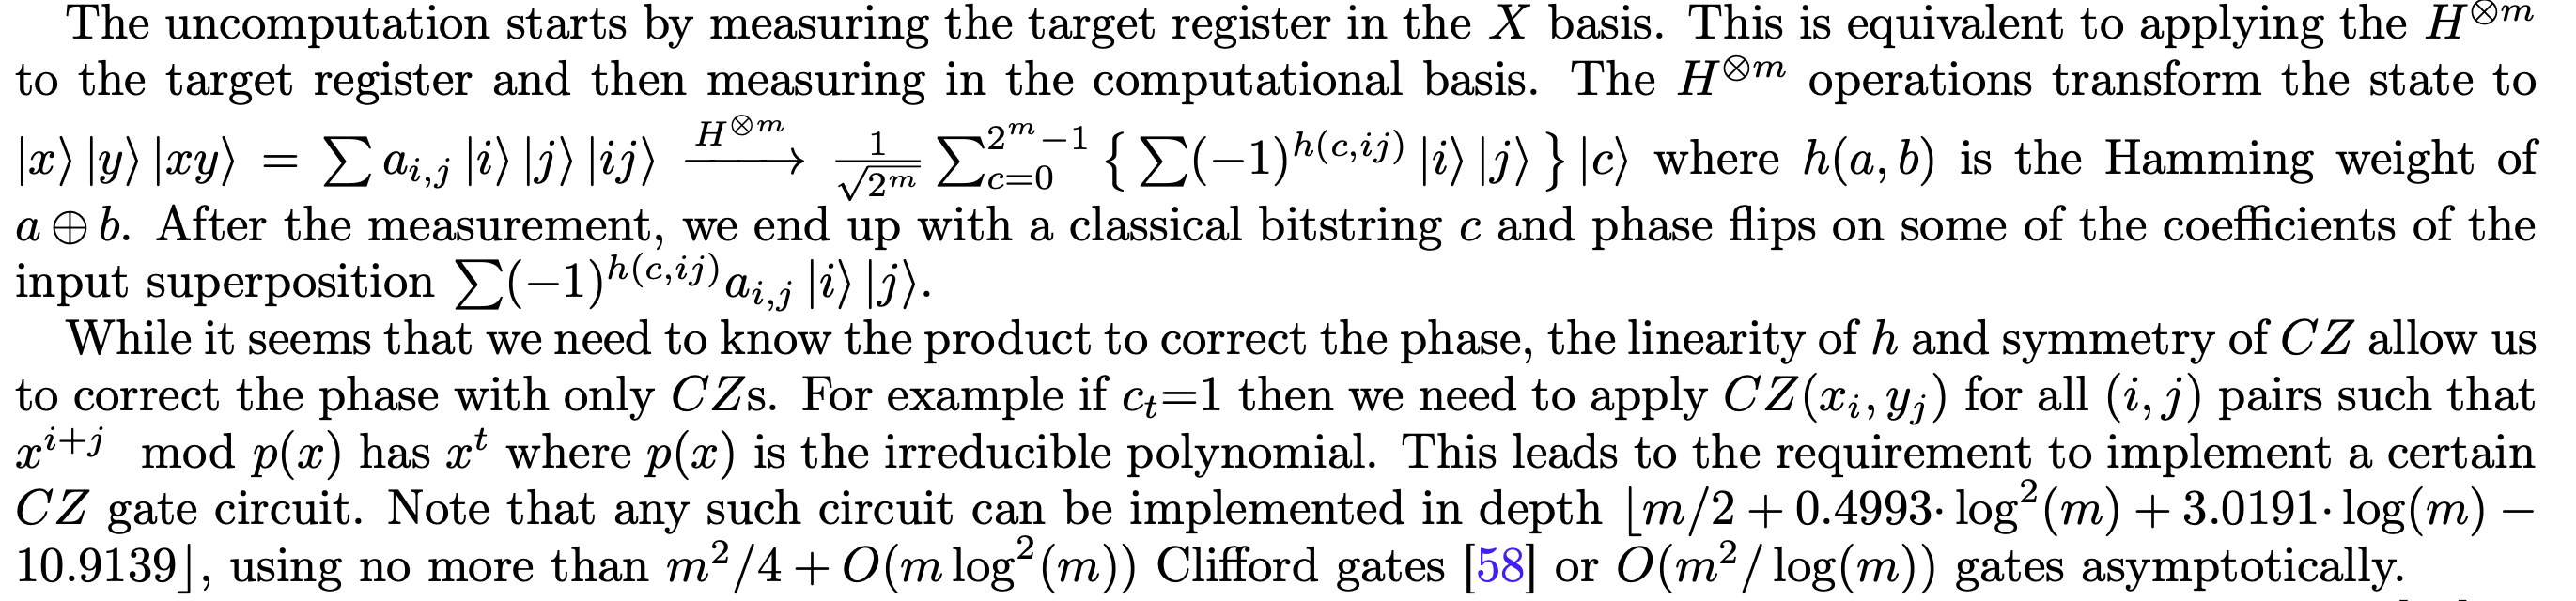